### Student Name : Sajin Mohamed Pallikkathodi Erathali  
### Student Id : 23037601  
### Student Name : Akshata BheemasamudraMallikarjunappa  
### Student Id : 23164204  

## The code executes completely without any error. We have implemented 3 versions of Deep Q Network.  
1. Vanilla DQN
2. Fixed DQN
3. Double DQN

# The following are some of the implementations we have adopted to obtain the results.  
1. Github:nitish-kalan. (2023). MountainCar-v0-Deep-Q-Learning-DQN-Keras: train_model.py. [Online]. Available at: https://github.com/nitish-kalan/MountainCar-v0-Deep-Q-Learning-DQN-Keras/blob/master/train_model.py [Accessed: 25 March, 2024].
2. Kaggle. (2020). Core SP20 RL Notebook. [Online]. Available at: https://www.kaggle.com/code/ucfaibot/core-sp20-rl/notebook [Accessed: 19 March, 2024].
3. Kaggle. (2020). Mountain Car is a Classic Reinforcement Learning Problem Notebook. [Online]. Available at: https://www.kaggle.com/code/rezafazel63/mountain-car-is-a-classic-reinforcement-learning/notebook [Accessed: 20 March, 2024].
4. Github:pylSER. (2021). Deep-Reinforcement-learning-Mountain-Car: MountainCarV2.py. [Online]. Available at: https://github.com/pylSER/Deep-Reinforcement-learning-Mountain-Car/blob/master/MountainCarV2.py [Accessed: 27 March, 2024].
5. rlpy. (2022). MountainCar.py. [Online]. Available at: https://github.com/rlpy/rlpy/blob/master/rlpy/Domains/MountainCar.py [Accessed: April 1, 2024].

# 1. Vanilla DQN

In [17]:
# Installing gym environment version 0.21.0
!pip install 'gym [atari,accept-rom-license]==0.21.0'


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Importing packages and libraries

In [1]:
import os
os.environ['SDL_VIDEODRIVER'] = 'dummy'
import gym
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pygame
from packaging import version
import tensorflow as tf
assert version.parse(tf.__version__) >= version.parse("2.15.0")

import random
from collections import deque

c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\tensorflow\__init__.py:30: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils as _distutils


In [2]:
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)

## Hyperparameters

In [3]:
# The number of sequential interacgtions the car has with its environment.
EPISODES = 600
# The size of the experience replay (section ---)
REPLAY_MEMORY_SIZE = 1_00_000
# Minimum size of experience replay required
MINIMUM_REPLAY_MEMORY = 1_000
# The number of sample we fetch from the experience replay during training
MINIBATCH_SIZE = 32
# The hyperparameter which balances exploration and exploitation by agent
EPSILON = 0.1
# The rate at which the epsilon decreases
EPSILON_DECAY = 0.99
MINIMUM_EPSILON = 0.001
# The discount factor which doiscunts future reward in favor of immediate reward (gamma)
DISCOUNT = 0.99
# The simulated environment used by the agent (car)
ENV_NAME = 'MountainCar-v0'

## Defining environment

In [4]:
# creates an environment
env = gym.make(ENV_NAME)
# Returns dimensionality of action space (0-> push left, 1-> no acceleration, 2-> push right)
action_dim = env.action_space.n
# Returns dimensionality of observation space (position [-1.2, 0.6], velocity[-0.07,0.07])
observation_dim = env.observation_space.shape

c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Defining Deep Q Network model

A sequential model with 400 input neurons and 300 neurons in the hidden layer and 3 in the output layer

In [5]:
# Creating simple sequential neural network model with 3 layers (400, 300, 2)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=observation_dim),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(action_dim, activation='linear')
])

'''Compiling the neural network using Mean Square Error as loss function and
Adam as the optimizer which will learn at a rate of 0.005'''
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))



c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Defining Epsilon greedy policy (section 5.1)

In [6]:
'''Defining epsilon greedy policy function to determine an action
to decide whether to explore or exploit the knowledge acquired'''
def epsilon_greedy_policy(state, epsilon):
    # Explore if random value from uniform distribution is less than exploration factor epsilon
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, action_dim)
        return action
    else:
    # Exploit
        action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0)[0])
        return action

## Defining the sample experience (section 2.1.1)

In [7]:
# Replay memory (experience replay) to store experiances of the model with the environment
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)

'''This function samples a minibatch of experiences from the replay buffer for training the model.'''
def sample_experience(MINIBATCH_SIZE):
    # random sampling  batch size(32) number of values from the replay buffer
    minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)
    # list to store the current state
    X_cur_states = []
    # list to store the next state
    X_next_states = []

    # populating the current and next states list
    for index, sample in enumerate(minibatch):
        cur_state, action, reward, next_state, done = sample
        X_cur_states.append(cur_state)
        X_next_states.append(next_state)

    # converting into arrays
    X_cur_states = np.array(X_cur_states)
    X_next_states = np.array(X_next_states)
    return minibatch,X_cur_states,X_next_states

## Defining the step function

In [8]:
max_reward = -999999


'''This function defines the steps the agent has to take based on the epsilon greedy policy
 and accumulates the reward'''
def play_one_step(env, state, epsilon, episode_length):
    # defining reward acquired in each episode
    global episode_reward
    # Calling epsilon greedy function to select action
    action = epsilon_greedy_policy(state, epsilon)
    # Executing the action and returns 4 values
    next_state, reward, done, info = env.step(action)
    # accumulating rewards in each step of the epsiode(max=-200)
    episode_reward += reward
    # truncating if the car reaches the flag on the mountain top within 200 steps
    if done and episode_length < 200:
        # If episode is ended then we have won the game. Defining Stratagem to make the agent learn faster
        reward = 250 + episode_reward
        # save the model weights if we get a epsiode reward greater than maximum reward defined
        if(episode_reward > max_reward):
            print("Saving the model with reward", episode_reward)
            model.save_weights("agent"+str(episode_reward)+"_agent_.weights.h5")
    else:
        # In oher cases reward will be proportional to the distance that car has travelled
        # from it's previous location + velocity of the car
        reward = 5*abs(next_state[0] - state[0]) + 3*abs(state[1])

    # append this result to the replay buffer(experince replay)
    replay_buffer.append((state, action, reward, next_state, done))

    return next_state, episode_reward, max_reward, done, info

## Defining the training function(Section 2.1)

In [9]:
rewards = []
'''The function creates and updates the q table and updates the model weights based on the Bellman's equation'''
def training_step(MINIBATCH_SIZE):
    # retrieving the array of values from the replay buffer
    minibatch, X_cur_states, X_next_states = sample_experience(MINIBATCH_SIZE)
    # predict state action values
    cur_action_values = model.predict(X_cur_states, verbose=0)

    # action values for the next_states taken from our agent (Q network)
    next_action_values = model.predict(X_next_states, verbose=0)

    for index, sample in enumerate(minibatch):

        cur_state, action, reward, next_state, done = sample
        # estimate the optimal state action values
        if not done:
            # Bellman's optimality equation
            '''A way to estimate the optimal state value of any state s(Q(st, at)) = sum of all discounted future rewards the agent can expect on average after it reaches a state s, assuming it acts optimally'''
            # Q(st, at) = reward + DISCOUNT * max(Q(s(t+1), a(t+1)))
            cur_action_values[index][action] = reward + DISCOUNT * np.amax(next_action_values[index])
        else:
            # Q(st, at) = reward
            cur_action_values[index][action] = reward

    # train the agent with new Q values for the states and the actions
    model.fit(X_cur_states, cur_action_values, verbose=0)




## Running the episodes

In [10]:
# Looping through episodes
for episode in range(EPISODES):
    # resetting the environment for the state to be reset
    state = env.reset()
    # initializing variables used
    done = False
    episode_reward = 0
    episode_length = 0

    # Running through different sets of steps
    while not done:
        # incrementing episode length(number of steps)
        episode_length += 1
        # calling the play_one_step function to execute the steps
        next_state, reward, max_reward, done, info  = play_one_step(env,state, EPSILON, episode_length)
        # update the current state with the next state for the episode to continue
        state = next_state

        # Checking if the replay buffer size is less than the minimum required replay buffer size for training to start
        if(len(replay_buffer) < MINIMUM_REPLAY_MEMORY):
            continue
        # when the minimum replay buffer size is populated
        training_step(MINIBATCH_SIZE)


    # recording the values for visualizing the results
    max_reward = max(reward, max_reward)
    print('Episode', episode, 'Episodic Reward', reward, 'Maximum Reward', max_reward, 'EPSILON', EPSILON)
    rewards.append(reward)

    # Epsilon decay for the next episode
    if(EPSILON > MINIMUM_EPSILON and len(replay_buffer) > MINIMUM_REPLAY_MEMORY):
        EPSILON *= EPSILON_DECAY

c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 1 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 2 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 3 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 4 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 5 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 6 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.099
Episode 7 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.09801
Episode 8 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0970299
Episode 9 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.096059601
Episode 10 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.09509900499
Episode 11 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0941480149401
Episode 12 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.093206534790699
Episode 13 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0922

## Plotting Rewards vs Episodes

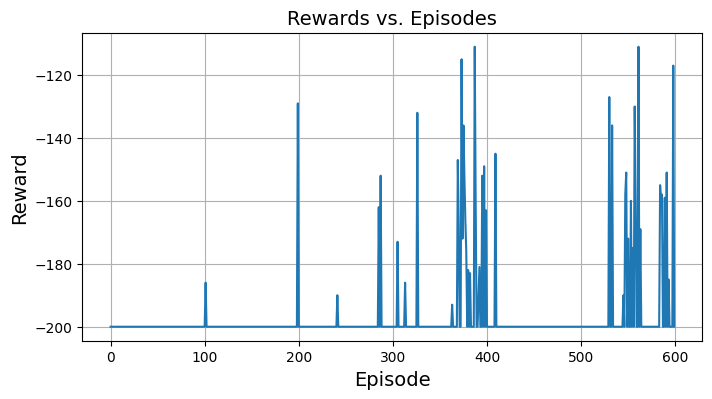

In [11]:
# model.set_weights(best_weights)
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Rewards vs. Episodes", fontsize=14)
plt.grid(True)
plt.show()

# Plotting Moving Average over 50 episodes

Text(0.5, 1.0, 'Moving average over 50 episodes')

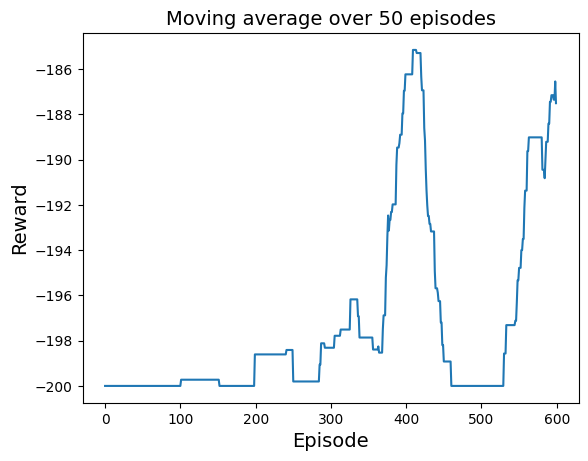

In [12]:
mean_rewards = np.zeros(600)
for t in range(600):
    mean_rewards[t] = np.mean(rewards[max(0, t-50):(t+1)])
plt.plot(mean_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Moving average over 50 episodes", fontsize=14)

## Testing the pre-trained model for 50 episodes

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
class DQNAgent:
    def __init__(self, action_dim, observation_dim):
        # Force keras to use the session that we have created

        self.action_dim = action_dim
        self.observation_dim = observation_dim
        self.model = self.create_model()

    def create_model(self):
        state_input = Input(shape=(self.observation_dim))
        state_h1 = Dense(400, activation='relu')(state_input)
        state_h2 = Dense(300, activation='relu')(state_h1)
        output = Dense(self.action_dim, activation='linear')(state_h2)
        model = Model(inputs=state_input, outputs=output)
        model.compile(loss='mse', optimizer=Adam(0.005))
        return model

In [ ]:
# Loading the model weights
model_weight_file = 'agent-115.0_agent_.weights.h5'

# Creating the environment
env = gym.make('MountainCar-v0')

# Getting the action and observation space
action_dim = env.action_space.n
observation_dim = env.observation_space.shape

# create and load weights of the model
agent = DQNAgent(action_dim, observation_dim)
agent.model.load_weights(model_weight_file)
# Number of episodes in which agent manages to won the game before time is over
episodes_won = 0
# Number of episodes for which we want to test the agnet
TOTAL_EPISODES = 50

# Looping through the episodes
for _ in range(TOTAL_EPISODES):
    cur_state = env.reset()
    done = False
    episode_len = 0
    while not done:

        episode_len += 1
        # Taking the action based on the model prediction
        next_state, reward, done, _ = env.step(np.argmax(agent.model.predict(np.expand_dims(cur_state, axis=0), verbose=0)))
        if done and episode_len < 200:
            episodes_won += 1
        cur_state = next_state

# Printing the number of episodes won by the agent
print(episodes_won, 'EPISODES WON AMONG', TOTAL_EPISODES, 'EPISODES')

48 EPISODES WON AMONG 50 EPISODES


<span style="color:green">This shows the game has reached the done state in under 200 episodes, which  means the car has reached the flag pole</span>

---------------------------------------------------------------------------------------------

# 2. Fixed DQN(Section 2.4)

<span style='color:red'> In the above code, we were constantly chignign the parameters(weights) of the network we defined to improve the Q-values predicted, however we were also using the changing Q-value predictions to update the Q-values. This can leadto instability in the training.  </span>

<span style='color:red'> Instead of updating the Q-values based on the continously changing network(training), we use a separate network(target network) to calculate the future Q-value in the Bellman equation. This target network has the same architecture as the training network, however, has frozen parameters(weights). These parameters are updated less frequently by copying the weights of the training network to the target network. Hence the target is more stable which helps to stabilize the training process.  </span>

<span style='color:red'> NOTE: In the code below we refer to training network as model and the target network as target_model1.  </span>


In [57]:
import random
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)
from collections import deque
input_shape = [2]


# Hyperparameters
EPISODES = 560
REPLAY_MEMORY_SIZE = 1_00_000
MINIMUM_REPLAY_MEMORY = 1_000
MINIBATCH_SIZE = 32
EPSILON = 1
EPSILON_DECAY = 0.99
MINIMUM_EPSILON = 0.001
DISCOUNT = 0.99
VISUALIZATION = False
ENV_NAME = 'MountainCar-v0'


# Environment details
env = gym.make(ENV_NAME)
action_dim = env.action_space.n
observation_dim = env.observation_space.shape

# defining the input shape and the number of outputs from the environment
input_shape = env.observation_space.shape  # Assuming self.observation_dim is a tuple
n_outputs = env.action_space.n

# Creating a simple sequential neural network model with 3 layers (400, 300, 2)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(n_outputs, activation='linear')
])
# Compiling the neural network using Mean Square Error as loss function and
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

# Cloning the model to create a target model
target_model1 = tf.keras.models.clone_model(model)

from collections import deque
# Replay memory to store experiances of the model with the environment
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)

'''Defining epsilon greedy policy function to determine an action
to decide whether to explore or exploit the knowledge acquired'''
def epsilon_greedy_policy(state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, action_dim)
        return action
    else:
        action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0)[0])
        return action

'''This function samples a batch of experiences from the replay buffer for training the model.'''
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ] 

max_reward = -999999
'''This function defines the steps the agent has to take based on the epsilon greedy policy
 and accumulates the reward'''
def play_one_step(env, state, epsilon, episode_length):
    # defining reward acquired in each episode
    global episode_reward
    # Calling epsilon greedy function to select action
    action = epsilon_greedy_policy(state, epsilon)
    # Executing the action and returns 4 values
    next_state, reward, done, info = env.step(action)
    # accumulating rewards in each step of the epsiode(max=-200)
    episode_reward += reward
    # truncating if the car reaches the flag on the mountain top within 200 steps
    if done and episode_length < 200:
        # If episode is ended then we have won the game. Defining Stratagem to make the agent learn faster
        reward = 250 + episode_reward
        # save the model weights if we get a epsiode reward greater than maximum reward defined
        if(episode_reward > max_reward):
            print("Saving the model with reward", episode_reward)
            model.save_weights("agent"+str(episode_reward)+"_agent_.weights.h5")
    else:
        # In oher cases reward will be proportional to the distance that car has travelled
        # from it's previous location + velocity of the car
        reward = 5*abs(next_state[0] - state[0]) + 3*abs(state[1])

    # append this result to the replay buffer(experince replay)
    replay_buffer.append((state, action, reward, next_state, done))

    return next_state, action, episode_reward, max_reward, done, info



np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-1)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):

    # Randomly sample a batch of experiences from the replay buffer
    minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)
    # Initialize lists to store the current and next states
    X_cur_states = []
    X_next_states = []

    # Populate the current and next states lists with data from the sampled experiences
    for index, sample in enumerate(minibatch):
        cur_state, action, reward, next_state, done = sample
        X_cur_states.append(cur_state)
        X_next_states.append(next_state)

    # Convert the lists to arrays
    X_cur_states = np.array(X_cur_states)
    X_next_states = np.array(X_next_states)

    # Initialize an array to store the Q values for the current state-action pairs
    cur_action_values = model.predict(X_cur_states, verbose =0)

    # Use the target model to predict the Q values for the next states
    next_action_values = target_model1.predict(X_next_states, verbose=0)
    
    '''Update the Q values for the current state-action pairs based on the rewards 
       and the maximum predicted Q values for the next states'''
    for index, sample in enumerate(minibatch):
        cur_state, action, reward, next_state, done = sample
        if not done:
            # if episode is not done then we have to calculate the Q value using Bellman's equation
            # Q(st, at) = rt + DISCOUNT * max(Q(s(t+1), a(t+1)))
            cur_action_values[index][action] = reward + DISCOUNT * np.amax(next_action_values[index])
        else:
            # if episode is done then Q value will be the reward
            # Q(st, at) = rt
            cur_action_values[index][action] = reward
            
    # train the agent with new Q values for the states and the actions
    model.fit(X_cur_states, cur_action_values, verbose=0)
    
# Initialize lists to store Q-values, positions, velocities, and actions taken
q_values = []
positions = []
velocities = []
actiion_taken = []

# Loop through the episodes
for episode in range(600):
    # Reset the environment for the state to be reset
    state = env.reset()
    done = False
    episode_reward = 0
    episode_length = 0

    # Run through different sets of steps untill 200 steps are completed or the car reaches the flag
    while not done:
        # Increment the episode length
        episode_length += 1

        # Play one step in the environment and get the next state, action, reward, max reward, done status, and info
        next_state, action, reward, max_reward, done, info  = play_one_step(env,state, EPSILON, episode_length)
        # Append the position, velocity, and action to their respective lists
        positions.append(next_state[0])
        velocities.append(next_state[1])
        actiion_taken.append(action)

        # Update the current state to the next state
        state = next_state

        # If the replay buffer is not large enough, skip the training step
        if(len(replay_buffer) < MINIMUM_REPLAY_MEMORY):
            continue
        training_step(batch_size)

    # Update the maximum reward if the current reward is greater
    max_reward = max(reward, max_reward)

    # Print the episode number, episodic reward, maximum reward, and epsilon
    print('Episode', episode, 'Episodic Reward', reward, 'Maximum Reward', max_reward, 'EPSILON', EPSILON)
    rewards.append(reward)
    # Append the mean Q-value of the current state to the Q-values list
    q_values.append(np.mean(model.predict(np.array([(state)]), verbose=0)[0]))
    
    # Every 20 episodes, update the weights of the target model with the weights of the training model
    if episode % 20 == 0:
        target_model1.set_weights(model.get_weights())
    
    # If epsilon is greater than the minimum epsilon and the replay buffer is large enough, decay epsilon
    if(EPSILON > MINIMUM_EPSILON and len(replay_buffer) > MINIMUM_REPLAY_MEMORY):
        EPSILON *= EPSILON_DECAY







Episode 0 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 1 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 2 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 3 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 4 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 5 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 1
Episode 6 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.99
Episode 7 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9801
Episode 8 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9702989999999999
Episode 9 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.96059601
Episode 10 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9509900498999999
Episode 11 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9414801494009999
Episode 12 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9320653479069899
Episode 13 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.9

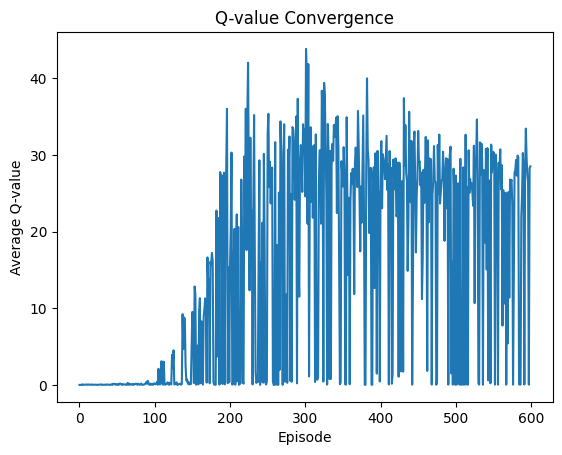

In [58]:

plt.plot(q_values)
plt.xlabel('Episode')
plt.ylabel('Average Q-value')
plt.title('Q-value Convergence')
plt.show()

# Plot Rewards vs episodes(Figure 4. Section 2.4.2)

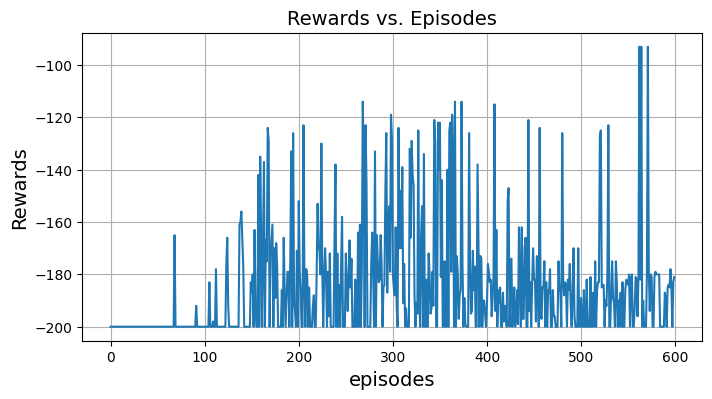

In [62]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("episodes", fontsize=14)
plt.ylabel("Rewards", fontsize=14)
plt.title("Rewards vs. Episodes", fontsize=14)
plt.grid(True)
plt.show()

# Plotting moving average of rewards over the last 50 episodes(Figure 5. Section 2.4.2)

Text(0.5, 1.0, 'Moving average over 50 episodes')

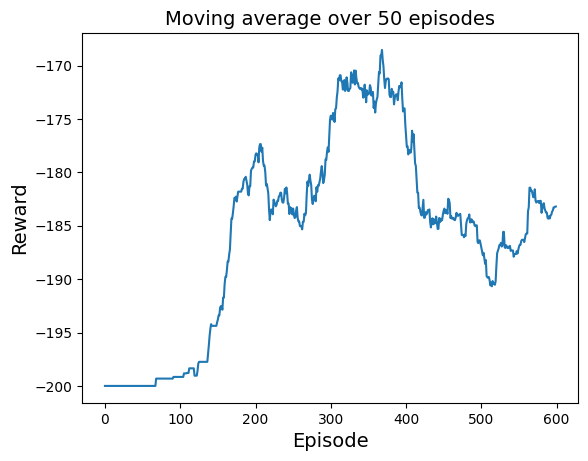

In [63]:
mean_rewards = np.zeros(600)
for t in range(600):
    # plotting the moving average over the last 50 episodes
    mean_rewards[t] = np.mean(rewards[max(0, t-50):(t+1)])
plt.plot(mean_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Moving average over 50 episodes", fontsize=14)

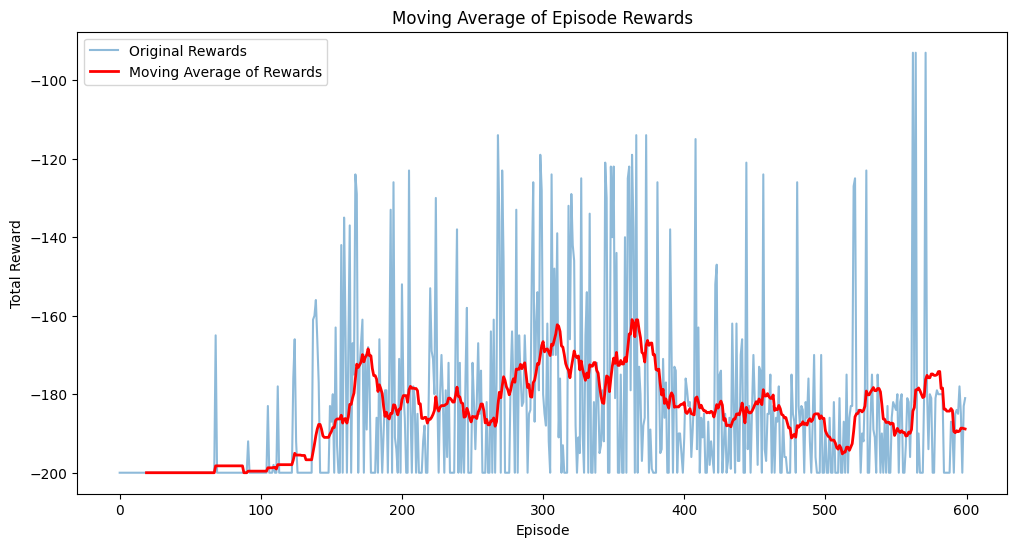

In [64]:
import pandas as pd
rewards_series = pd.Series(rewards)
window_size = 20
rewards_moving_average = rewards_series.rolling(window=window_size).mean()
plt.figure(figsize=(12, 6))
plt.plot(rewards, alpha=0.5, label='Original Rewards')
plt.plot(rewards_moving_average, color='red', linewidth=2, label='Moving Average of Rewards')
plt.title("Moving Average of Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.show()


## Position vs. Velocity(Figure 6. Section 2.4.2)

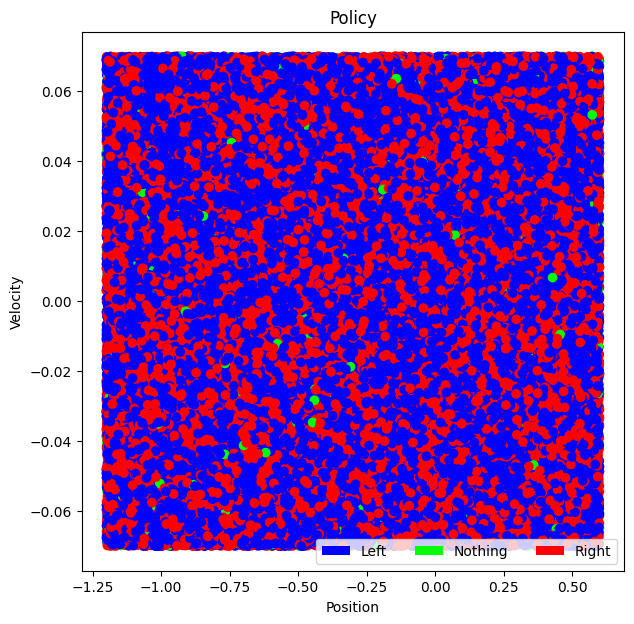

In [67]:
import matplotlib.patches as mpatches
# List of possible positions
X = np.random.uniform(-1.2, 0.6, 111043)
# List of possible velocities
Y = np.random.uniform(-0.07, 0.07, 111043)

# For each possible state, retreive the most rewarding action and record it
actions = []

colors = {0:'blue',1:'lime',2:'red'}
# Convert action_taken to array
actions = np.array(actiion_taken)
# Map action indices to colors
colors = np.array([colors[action] for action in actions])
labels = ['Left',  'Nothing', 'Right']

# Visualize the policy
fig = plt.figure(3, figsize=[7,7])
ax = fig.gca()
plt.set_cmap('brg')
# Plot scatter plot with X and Y as state[0] and state[1]
surf = ax.scatter(X, Y, c=colors)
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Policy')
recs = []
unique_colors = np.unique(colors)
for i in range(len(unique_colors)):
     recs.append(mpatches.Rectangle((0,0),1,1,fc=unique_colors[i]))
plt.legend(recs,labels,loc=4,ncol=3)
plt.show()


<span style='color:green'>The above position vs velocity graph tells us the actions taken by the car at each position and velocity. As expected the car(agent) chose to move left(blue) and right(red) more often than staying and doing nothing(green). This tells us that the agent was constantly moving around except for a fewew occasions where the reward obtained from it doing nothing, outweighed the rewards from moving left or right, as per Bellman Equation.</span>

---------------------------------------------------------------------------------------------

# 3. Double DQN

<span style ='color:red'> There are two problems with vanilla DQN and Fixed DQN -> Maximization bias which is the problem of overestimating the action-values of a state, that is, the agent tends to believe certain actions are valuable even though it is not so. And this happens because we are referring to the same table values to select an action and evaluate that action. -> Catastrophic forgetting   </span>

<span style ='color:red'> The solution to this problem of overestimation is using two different Q tables (that is two different neural network models). 
The best action can be taken based on the first Q table values and tha target value can be taken on the second Q table values </span>

<span style ='color:red'> Training the above two networks (Q1 + Q2) is based on "flip coin" approach (that is decisions are made randomly) and here, the main Q network model (Q1) is used to select the action(a) and the target network model (Q2) is used to evaluate that action(a) for the first half of randomness say when randomness < 0.5 and vice versa when randomness is > 0.5.  </span>

Following this method helps the agent to not overestimate for both the halves of the action values in the Q tables (randomness < 0.5 and randomness > 0.5). </span>



## Importing required packages and libraries

In [13]:
import imageio
import matplotlib.pyplot as plt
import pandas as pd

In [14]:

random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)

## Defining Hyperparameters

In [22]:
# The number of sequential interacgtions the car has with its environment.
EPISODES = 600
# The size of the experience replay (section ---)
REPLAY_MEMORY_SIZE = 1_00_000
# Minimum size of experience replay required
MINIMUM_REPLAY_MEMORY = 1_000
# The number of sample we fetch from the experience replay during training
MINIBATCH_SIZE = 32
# The hyperparameter which balances exploration and exploitation by agent
EPSILON = 0.1
# The rate at which the epsilon decreases
EPSILON_DECAY = 0.99
MINIMUM_EPSILON = 0.001
# The discount factor which doiscunts future reward in favor of immediate reward (gamma)
DISCOUNT = 0.99
# The number of episodes before run before the learning is recorded
record_frequency = 20

## Defining the Simulated Environment

In [23]:
# The simulated environment used by the agent (car)
ENV_NAME = 'MountainCar-v0'
# Creates an environment
env = gym.make(ENV_NAME)
# Returns dimensionality of action space (0-> push left, 1-> no acceleration, 2-> push right)
action_dim = env.action_space.n
# Returns dimensionality of observation space (position [-1.2, 0.6], velocity[-0.07,0.07])
observation_dim = env.observation_space.shape

c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Defining Deep Q Network model and Target Network Model

In [24]:

# Creating simple sequential neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(400, activation='relu', input_shape=observation_dim),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(action_dim, activation='linear')
])

'''Compiling the neural network using Mean Square Error as loss function and
Adam as the optimizer which will learn at a rate of 0.005'''
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))
# Creating target network model which is the same as Deep Q network by cloning it
target_model1 = tf.keras.models.clone_model(model)

c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Defining Epsilon Greedy Policy

In [25]:
'''Defining epsilon greedy policy function to determine an action
to decide whether to explore or exploit the knowledge acquired'''
def epsilon_greedy_policy(state, epsilon):
    # Explore if random value from uniform distribution is less than exploration factor epsilon
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, action_dim)
        return action
    else:
    # Exploit
        action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0)[0])
        return action

## Defining the step function

In [26]:
max_reward = -999999


'''This function defines the steps the agent has to take based on the epsilon greedy policy
 and accumulates the reward'''
def play_one_step(env, state, epsilon, episode_length):
    # defining reward acquired in each episode
    global episode_reward
    # Calling epsilon greedy function to select action
    action = epsilon_greedy_policy(state, epsilon)
    # Executing the action and returns 4 values
    next_state, reward, done, info = env.step(action)
    # accumulating rewards in each step of the epsiode(max=-200)
    episode_reward += reward
    # truncating if the car reaches the flag on the mountain top within 200 steps
    if done and episode_length < 200:
        # If episode is ended then we have won the game. Defining Stratagem to make the agent learn faster
        reward = 250 + episode_reward
        # save the model weights if we get a epsiode reward greater than maximum reward defined
        if(episode_reward > max_reward):
            print("Saving the model with reward", episode_reward)
            model.save_weights("agent"+str(episode_reward)+"_agent_.weights.h5")
    else:
        # In oher cases reward will be proportional to the distance that car has travelled
        # from it's previous location + velocity of the car
        reward = 5*abs(next_state[0] - state[0]) + 3*abs(state[1])

    # append this result to the replay buffer(experince replay)
    replay_buffer.append((state, action, reward, next_state, done))

    return next_state, episode_reward, max_reward, done, info

## Sampling experience and Training function

In [27]:
# Replay memory (experience replay) to store experiances of the model with the environment
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)
rewards = []

def training_step(MINIBATCH_SIZE):
    # Samples batches of size MiniBatch_size(32) from  the replay buffer
    minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)
    # Array containing current state values from each sample in the minibatch as the replay buffer looks like (state, action, reward, next_state, done)
    X_cur_states = np.array([sample[0] for sample in minibatch])
    # Array containing next state values from each sample in the minibatch as the replay buffer looks like (state, action, reward, next_state, done)
    X_next_states = np.array([sample[3] for sample in minibatch])
    # Predicting the action using main neural network 
    '''The inputs for the Neural Network selecting the action using main network.
    This uses the main neural network model to predict the current Q-values for all actions given the current states'''
    cur_action_values = model.predict(X_cur_states, verbose=0)
    ''' This step predicts the Q-values for the next states using the same main network and
    helps to decide the next action to take'''
    # Q1(a)
    next_action_values_main = model.predict(X_next_states, verbose=0)
    # Evaluating the action using target network
    ''' This uses a separate target network to predict the Q-values for the next states. 
    This target network is an older version of the main network and is used to stabilize the training'''
    # Q2(a)
    next_action_values_target = target_model1.predict(X_next_states, verbose=0)
    # This loop iterates over each sample from sample experience
    for index, (cur_state, action, reward, next_state, done) in enumerate(minibatch):
        # If the episode is not completed,
        if not done:
            ''' Using "coin flip" approach to randomly select the networks to be used 
            for predicting an action and evaluate the selected action during training'''
            if np.random.rand() < 0.5:
                # Return action with highest Q value in next state as per the main neural network
                # Q2(A*) = Q2(argmax(Q1(a)))
                best_action_next = np.argmax(next_action_values_main[index])
                ''' The bellman equation is updated to to return Q value for the action taken using reward, 
                discount and best next action from the target network and not the main network'''
                # E|Q2(A*)| = q(A*)
                cur_action_values[index][action] = reward + DISCOUNT * next_action_values_target[index][best_action_next]
            else:
                # Q1(A*) = Q1(argmax(Q2(a)))
                best_action_next = np.argmax(next_action_values_target[index])
                ''' The bellman equation is updated to to return Q value for the action taken using reward, 
                discount and best next action from the target network and not the main network'''
                # E|Q1(A*)| = q(A*)
                cur_action_values[index][action] = reward + DISCOUNT * next_action_values_main[index][best_action_next]      
        else:
            cur_action_values[index][action] = reward
    # updates model weights using Q values to minimize the error between target value and predicted value.
    model.fit(X_cur_states, cur_action_values, verbose=0)

## Running the episodes

In [28]:
episode_lengths = [] 
# Looping through episodes
for episode in range(EPISODES):
    # resetting the environment for the state to be reset
    state = env.reset()
    # initializing variables used
    done = False
    episode_reward = 0
    episode_length = 0
    # creating a list to capture and append the learning through animation
    frames = []

    # Running through different sets of steps
    while not done:
        # incrementing episode length(number of steps)
        episode_length += 1
        # calling the play_one_step function to execute the steps
        next_state, reward, max_reward, done, info  = play_one_step(env,state, EPSILON, episode_length)
        # update the current state with the next state for the episode to continue
        state = next_state

        # Checking if the replay buffer size is less than the minimum required replay buffer size for training to start
        if(len(replay_buffer) < MINIMUM_REPLAY_MEMORY):
            continue
        # when the minimum replay buffer size is populated
        training_step(MINIBATCH_SIZE)

        # Recording and collecting the learning through frames for every 20 episodes
        if episode % record_frequency ==0:
            frames.append(env.render(mode='rgb_array'))

    # Creating learning animation
    if episode % record_frequency ==0:
            imageio.mimsave(f'episode_{episode}.mp4', frames, fps=30)

    # recording the values for visualizing the results
    max_reward = max(reward, max_reward)
    print('Episode', episode, 'Episodic Reward', reward, 'Maximum Reward', max_reward, 'EPSILON', EPSILON)
    rewards.append(reward)

    # Saving the weights for the episode that received maximum reward
    if episode % 20 == 0:
        target_model1.set_weights(model.get_weights())
    # Epsilon decay for the next episode
    if(EPSILON > MINIMUM_EPSILON and len(replay_buffer) > MINIMUM_REPLAY_MEMORY):
        EPSILON *= EPSILON_DECAY

    # recording the number of time steps taken by agent from the beginning of an episode to its termination
    episode_lengths.append(episode_length)

c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 1 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 2 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 3 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 4 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 5 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.1
Episode 6 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.099
Episode 7 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.09801
Episode 8 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0970299
Episode 9 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.096059601
Episode 10 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.09509900499
Episode 11 Episodic Reward -200.0 Maximum Reward -200.0 EPSILON 0.0941480149401
Saving the model with reward -164.0
Episode 12 Episodic Reward -164.0 Maximum Reward -164.0 EPSILON 0.093206534790699
Episode 13 Episodic Reward -192.0 

c:\Users\91776\Desktop\Masters\UL\Modules\RL\venv\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 20 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.08600583546412884
Episode 21 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.08514577710948755
Episode 22 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.08429431933839267
Episode 23 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.08345137614500873
Episode 24 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.08261686238355864
Episode 25 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.08179069375972306
Episode 26 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.08097278682212583
Episode 27 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.08016305895390458
Episode 28 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.07936142836436554
Episode 29 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.07856781408072187
Episode 30 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.07778213593991465
Episode 31 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.0770043145

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 40 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.07034476949995691
Episode 41 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.06964132180495734
Episode 42 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.06894490858690777
Episode 43 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.06825545950103869
Episode 44 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.0675729049060283
Episode 45 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.06689717585696801
Episode 46 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.06622820409839833
Episode 47 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.06556592205741435
Episode 48 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.0649102628368402
Episode 49 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.06426116020847181
Episode 50 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.06361854860638709
Episode 51 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.062982363120

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 60 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.05753547499769285
Episode 61 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.05696012024771592
Episode 62 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.05639051904523876
Episode 63 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.05582661385478637
Episode 64 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.05526834771623851
Episode 65 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.054715664239076124
Episode 66 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.054168507596685365
Episode 67 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.053626822520718515
Episode 68 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.05309055429551133
Episode 69 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.05255964875255621
Episode 70 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.05203405226503065
Episode 71 Episodic Reward -196.0 Maximum Reward -164.0 EPSILON 0.0515137

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 80 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.047058664158565
Episode 81 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.046588077516979354
Episode 82 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.04612219674180956
Episode 83 Episodic Reward -181.0 Maximum Reward -164.0 EPSILON 0.04566097477439147
Episode 84 Episodic Reward -189.0 Maximum Reward -164.0 EPSILON 0.045204365026647556
Episode 85 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.04475232137638108
Episode 86 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.044304798162617266
Episode 87 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.043861750180991095
Episode 88 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.04342313267918119
Episode 89 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.04298890135238938
Episode 90 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.042559012338865485
Episode 91 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.0421334

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 100 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.03848960788934848
Episode 101 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.038104711810454994
Episode 102 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.037723664692350445
Episode 103 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.03734642804542694
Episode 104 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.03697296376497267
Episode 105 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.03660323412732295
Episode 106 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.03623720178604972
Episode 107 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.035874829768189224
Episode 108 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.03551608147050733
Episode 109 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.03516092065580226
Episode 110 Episodic Reward -188.0 Maximum Reward -164.0 EPSILON 0.034809311449244235
Episode 111 Episodic Reward -200.0 Maximum Reward -164.0 EPSI

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 120 Episodic Reward -182.0 Maximum Reward -164.0 EPSILON 0.03148091731809525
Episode 121 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.031166108144914297
Episode 122 Episodic Reward -166.0 Maximum Reward -164.0 EPSILON 0.030854447063465153
Episode 123 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.030545902592830503
Episode 124 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.030240443566902198
Episode 125 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.029938039131233177
Episode 126 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.029638658739920845
Episode 127 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.029342272152521637
Episode 128 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.02904884943099642
Episode 129 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.028758360936686458
Episode 130 Episodic Reward -200.0 Maximum Reward -164.0 EPSILON 0.028470777327319594
Episode 131 Episodic Reward -200.0 Maximum Reward -164.0

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 140 Episodic Reward -197.0 Maximum Reward -138.0 EPSILON 0.025748460676394917
Episode 141 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.025490976069630966
Episode 142 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.025236066308934657
Episode 143 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.02498370564584531
Episode 144 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.024733868589386858
Episode 145 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.02448652990349299
Episode 146 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.02424166460445806
Episode 147 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.02399924795841348
Episode 148 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.023759255478829344
Episode 149 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.02352166292404105
Episode 150 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.02328644629480064
Episode 151 Episodic Reward -200.0 Maximum Reward -138.0 EPS

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 160 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.021059844619672884
Episode 161 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.020849246173476155
Episode 162 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.020640753711741393
Episode 163 Episodic Reward -156.0 Maximum Reward -138.0 EPSILON 0.020434346174623978
Episode 164 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.020230002712877736
Episode 165 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.02002770268574896
Episode 166 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.01982742565889147
Episode 167 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.019629151402302553
Episode 168 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.019432859888279527
Episode 169 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.019238531289396732
Episode 170 Episodic Reward -200.0 Maximum Reward -138.0 EPSILON 0.019046145976502765
Episode 171 Episodic Reward -200.0 Maximum Reward -138.0

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 180 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01722499301915016
Episode 181 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01705274308895866
Episode 182 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01688221565806907
Episode 183 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01671339350148838
Episode 184 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.016546259566473494
Episode 185 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01638079697080876
Episode 186 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.016216989001100673
Episode 187 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.016054819111089667
Episode 188 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01589427091997877
Episode 189 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01573532821077898
Episode 190 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.015577974928671192
Episode 191 Episodic Reward -200.0 Maximum Reward -120.0 EPSI

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 200 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.014088441290426785
Episode 201 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.013947556877522518
Episode 202 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.013808081308747293
Episode 203 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01367000049565982
Episode 204 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.013533300490703223
Episode 205 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01339796748579619
Episode 206 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.013263987810938228
Episode 207 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.013131347932828845
Episode 208 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.013000034453500557
Episode 209 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.01287003410896555
Episode 210 Episodic Reward -200.0 Maximum Reward -120.0 EPSILON 0.012741333767875895
Saving the model with reward -86.0
Episode 211 Episodic R

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 220 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.011523033871371349
Episode 221 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.011407803532657634
Episode 222 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.011293725497331058
Episode 223 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.011180788242357747
Episode 224 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.01106898035993417
Episode 225 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.010958290556334828
Episode 226 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.01084870765077148
Episode 227 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.010740220574263765
Episode 228 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.010632818368521127
Episode 229 Episodic Reward -167.0 Maximum Reward -86.0 EPSILON 0.010526490184835915
Episode 230 Episodic Reward -200.0 Maximum Reward -86.0 EPSILON 0.010421225282987556
Episode 231 Episodic Reward -184.0 Maximum Reward -86.0 EPSILON 0.0

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 240 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.009424769345562502
Episode 241 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.009330521652106877
Episode 242 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.009237216435585808
Episode 243 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.009144844271229951
Episode 244 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.00905339582851765
Episode 245 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.008962861870232474
Episode 246 Episodic Reward -180.0 Maximum Reward -85.0 EPSILON 0.008873233251530149
Episode 247 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.008784500919014848
Episode 248 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.0086966559098247
Episode 249 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.008609689350726452
Episode 250 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.008523592457219188
Episode 251 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.00

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 260 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.0077085842329892825
Episode 261 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.00763149839065939
Episode 262 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.0075551834067527955
Episode 263 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.007479631572685268
Episode 264 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.007404835256958415
Episode 265 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.007330786904388831
Episode 266 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.007257479035344943
Episode 267 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.007184904244991494
Episode 268 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.007113055202541579
Episode 269 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.007041924650516163
Episode 270 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 0.006971505404011002
Episode 271 Episodic Reward -200.0 Maximum Reward -85.0 EPSILON 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 280 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.006304904523214563
Episode 281 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.006241855477982417
Episode 282 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0061794369232025925
Episode 283 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.006117642553970567
Episode 284 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.006056466128430861
Episode 285 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.005995901467146553
Episode 286 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.005935942452475087
Episode 287 Episodic Reward -160.0 Maximum Reward -84.0 EPSILON 0.005876583027950337
Episode 288 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.005817817197670833
Episode 289 Episodic Reward -168.0 Maximum Reward -84.0 EPSILON 0.005759639025694124
Episode 290 Episodic Reward -99.0 Maximum Reward -84.0 EPSILON 0.005702042635437183
Episode 291 Episodic Reward -199.0 Maximum Reward -84.0 EPSILON 0

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 300 Episodic Reward -159.0 Maximum Reward -84.0 EPSILON 0.005156825150425352
Episode 301 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.005105256898921099
Episode 302 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.005054204329931888
Episode 303 Episodic Reward -126.0 Maximum Reward -84.0 EPSILON 0.005003662286632569
Episode 304 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.004953625663766243
Episode 305 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.00490408940712858
Episode 306 Episodic Reward -133.0 Maximum Reward -84.0 EPSILON 0.004855048513057294
Episode 307 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.004806498027926721
Episode 308 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.004758433047647454
Episode 309 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.004710848717170979
Episode 310 Episodic Reward -176.0 Maximum Reward -84.0 EPSILON 0.004663740229999269
Episode 311 Episodic Reward -150.0 Maximum Reward -84.0 EPSILON 0.

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 320 Episodic Reward -186.0 Maximum Reward -84.0 EPSILON 0.004217803066508778
Episode 321 Episodic Reward -145.0 Maximum Reward -84.0 EPSILON 0.00417562503584369
Episode 322 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.004133868785485253
Episode 323 Episodic Reward -173.0 Maximum Reward -84.0 EPSILON 0.004092530097630401
Episode 324 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.004051604796654096
Episode 325 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.004011088748687555
Episode 326 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.003970977861200679
Episode 327 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.003931268082588672
Episode 328 Episodic Reward -101.0 Maximum Reward -84.0 EPSILON 0.0038919554017627853
Episode 329 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0038530358477451574
Episode 330 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.003814505489267706
Episode 331 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 340 Episodic Reward -97.0 Maximum Reward -84.0 EPSILON 0.003449770389516402
Episode 341 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.003415272685621238
Episode 342 Episodic Reward -163.0 Maximum Reward -84.0 EPSILON 0.003381119958765026
Episode 343 Episodic Reward -196.0 Maximum Reward -84.0 EPSILON 0.0033473087591773757
Episode 344 Episodic Reward -176.0 Maximum Reward -84.0 EPSILON 0.003313835671585602
Episode 345 Episodic Reward -171.0 Maximum Reward -84.0 EPSILON 0.003280697314869746
Episode 346 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.003247890341721049
Episode 347 Episodic Reward -164.0 Maximum Reward -84.0 EPSILON 0.003215411438303838
Episode 348 Episodic Reward -163.0 Maximum Reward -84.0 EPSILON 0.0031832573239207996
Episode 349 Episodic Reward -91.0 Maximum Reward -84.0 EPSILON 0.0031514247506815914
Episode 350 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0031199105031747753
Episode 351 Episodic Reward -132.0 Maximum Reward -84.0 EPSILON

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 360 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.002821591134702967
Episode 361 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0027933752233559373
Episode 362 Episodic Reward -155.0 Maximum Reward -84.0 EPSILON 0.002765441471122378
Episode 363 Episodic Reward -162.0 Maximum Reward -84.0 EPSILON 0.002737787056411154
Episode 364 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0027104091858470426
Episode 365 Episodic Reward -119.0 Maximum Reward -84.0 EPSILON 0.002683305093988572
Episode 366 Episodic Reward -163.0 Maximum Reward -84.0 EPSILON 0.0026564720430486866
Episode 367 Episodic Reward -114.0 Maximum Reward -84.0 EPSILON 0.0026299073226182
Episode 368 Episodic Reward -157.0 Maximum Reward -84.0 EPSILON 0.0026036082493920178
Episode 369 Episodic Reward -160.0 Maximum Reward -84.0 EPSILON 0.0025775721668980975
Episode 370 Episodic Reward -117.0 Maximum Reward -84.0 EPSILON 0.0025517964452291164
Episode 371 Episodic Reward -200.0 Maximum Reward -84.0 EPSIL

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 380 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0023077989641364
Episode 381 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.002284720974495036
Episode 382 Episodic Reward -118.0 Maximum Reward -84.0 EPSILON 0.0022618737647500855
Episode 383 Episodic Reward -125.0 Maximum Reward -84.0 EPSILON 0.002239255027102585
Episode 384 Episodic Reward -142.0 Maximum Reward -84.0 EPSILON 0.002216862476831559
Episode 385 Episodic Reward -128.0 Maximum Reward -84.0 EPSILON 0.0021946938520632435
Episode 386 Episodic Reward -120.0 Maximum Reward -84.0 EPSILON 0.002172746913542611
Episode 387 Episodic Reward -116.0 Maximum Reward -84.0 EPSILON 0.0021510194444071848
Episode 388 Episodic Reward -126.0 Maximum Reward -84.0 EPSILON 0.002129509249963113
Episode 389 Episodic Reward -117.0 Maximum Reward -84.0 EPSILON 0.002108214157463482
Episode 390 Episodic Reward -130.0 Maximum Reward -84.0 EPSILON 0.0020871320158888473
Episode 391 Episodic Reward -121.0 Maximum Reward -84.0 EPSILON

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 400 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0018875647833468641
Episode 401 Episodic Reward -155.0 Maximum Reward -84.0 EPSILON 0.0018686891355133954
Episode 402 Episodic Reward -114.0 Maximum Reward -84.0 EPSILON 0.0018500022441582614
Episode 403 Episodic Reward -123.0 Maximum Reward -84.0 EPSILON 0.0018315022217166787
Episode 404 Episodic Reward -127.0 Maximum Reward -84.0 EPSILON 0.001813187199499512
Episode 405 Episodic Reward -115.0 Maximum Reward -84.0 EPSILON 0.0017950553275045168
Episode 406 Episodic Reward -153.0 Maximum Reward -84.0 EPSILON 0.0017771047742294716
Episode 407 Episodic Reward -115.0 Maximum Reward -84.0 EPSILON 0.001759333726487177
Episode 408 Episodic Reward -123.0 Maximum Reward -84.0 EPSILON 0.001741740389222305
Episode 409 Episodic Reward -115.0 Maximum Reward -84.0 EPSILON 0.001724322985330082
Episode 410 Episodic Reward -123.0 Maximum Reward -84.0 EPSILON 0.0017070797554767812
Episode 411 Episodic Reward -124.0 Maximum Reward -84.0 EP

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 420 Episodic Reward -114.0 Maximum Reward -84.0 EPSILON 0.001543852331463614
Episode 421 Episodic Reward -112.0 Maximum Reward -84.0 EPSILON 0.0015284138081489778
Episode 422 Episodic Reward -149.0 Maximum Reward -84.0 EPSILON 0.001513129670067488
Episode 423 Episodic Reward -123.0 Maximum Reward -84.0 EPSILON 0.0014979983733668131
Episode 424 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.001483018389633145
Episode 425 Episodic Reward -113.0 Maximum Reward -84.0 EPSILON 0.0014681882057368135
Episode 426 Episodic Reward -112.0 Maximum Reward -84.0 EPSILON 0.0014535063236794453
Episode 427 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0014389712604426508
Episode 428 Episodic Reward -113.0 Maximum Reward -84.0 EPSILON 0.0014245815478382243
Episode 429 Episodic Reward -122.0 Maximum Reward -84.0 EPSILON 0.001410335732359842
Episode 430 Episodic Reward -114.0 Maximum Reward -84.0 EPSILON 0.0013962323750362437
Episode 431 Episodic Reward -112.0 Maximum Reward -84.0 EP

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 440 Episodic Reward -111.0 Maximum Reward -84.0 EPSILON 0.0012627275325297494
Episode 441 Episodic Reward -105.0 Maximum Reward -84.0 EPSILON 0.0012501002572044518
Episode 442 Episodic Reward -176.0 Maximum Reward -84.0 EPSILON 0.0012375992546324072
Episode 443 Episodic Reward -165.0 Maximum Reward -84.0 EPSILON 0.0012252232620860832
Episode 444 Episodic Reward -112.0 Maximum Reward -84.0 EPSILON 0.0012129710294652223
Episode 445 Episodic Reward -112.0 Maximum Reward -84.0 EPSILON 0.0012008413191705702
Episode 446 Episodic Reward -185.0 Maximum Reward -84.0 EPSILON 0.0011888329059788645
Episode 447 Episodic Reward -120.0 Maximum Reward -84.0 EPSILON 0.001176944576919076
Episode 448 Episodic Reward -155.0 Maximum Reward -84.0 EPSILON 0.0011651751311498853
Episode 449 Episodic Reward -111.0 Maximum Reward -84.0 EPSILON 0.0011535233798383865
Episode 450 Episodic Reward -116.0 Maximum Reward -84.0 EPSILON 0.0011419881460400026
Episode 451 Episodic Reward -113.0 Maximum Reward -84.0

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 460 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.001032793609151115
Episode 461 Episodic Reward -123.0 Maximum Reward -84.0 EPSILON 0.0010224656730596037
Episode 462 Episodic Reward -117.0 Maximum Reward -84.0 EPSILON 0.0010122410163290077
Episode 463 Episodic Reward -115.0 Maximum Reward -84.0 EPSILON 0.0010021186061657176
Episode 464 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 465 Episodic Reward -116.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 466 Episodic Reward -178.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 467 Episodic Reward -123.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 468 Episodic Reward -111.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 469 Episodic Reward -112.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 470 Episodic Reward -183.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 471 Episodic Reward -200.0 Maximum Reward -84.0

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 480 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 481 Episodic Reward -117.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 482 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 483 Episodic Reward -195.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 484 Episodic Reward -129.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 485 Episodic Reward -112.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 486 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 487 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 488 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 489 Episodic Reward -112.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 490 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 491 Episodic Reward -117.0 Maximum Reward -84.

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 500 Episodic Reward -121.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 501 Episodic Reward -110.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 502 Episodic Reward -111.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 503 Episodic Reward -127.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 504 Episodic Reward -116.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 505 Episodic Reward -116.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 506 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 507 Episodic Reward -123.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 508 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 509 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 510 Episodic Reward -149.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 511 Episodic Reward -160.0 Maximum Reward -84.

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 520 Episodic Reward -122.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 521 Episodic Reward -147.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 522 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 523 Episodic Reward -116.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 524 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 525 Episodic Reward -118.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 526 Episodic Reward -115.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 527 Episodic Reward -113.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 528 Episodic Reward -116.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 529 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 530 Episodic Reward -115.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 531 Episodic Reward -117.0 Maximum Reward -84.

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 540 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 541 Episodic Reward -124.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 542 Episodic Reward -116.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 543 Episodic Reward -117.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 544 Episodic Reward -119.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 545 Episodic Reward -110.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 546 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 547 Episodic Reward -119.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 548 Episodic Reward -113.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 549 Episodic Reward -119.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 550 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 551 Episodic Reward -113.0 Maximum Reward -84.

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 560 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 561 Episodic Reward -113.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 562 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 563 Episodic Reward -114.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 564 Episodic Reward -110.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 565 Episodic Reward -115.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 566 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 567 Episodic Reward -142.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 568 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 569 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 570 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 571 Episodic Reward -115.0 Maximum Reward -84.

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 580 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 581 Episodic Reward -155.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 582 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 583 Episodic Reward -114.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 584 Episodic Reward -110.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 585 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 586 Episodic Reward -175.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 587 Episodic Reward -120.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 588 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 589 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 590 Episodic Reward -200.0 Maximum Reward -84.0 EPSILON 0.0009920974201040604
Episode 591 Episodic Reward -200.0 Maximum Reward -84.

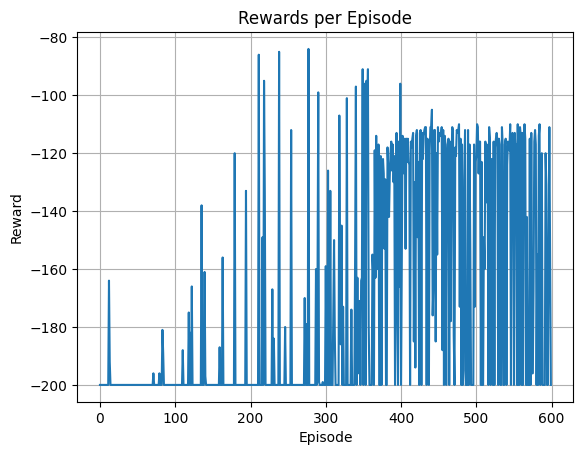

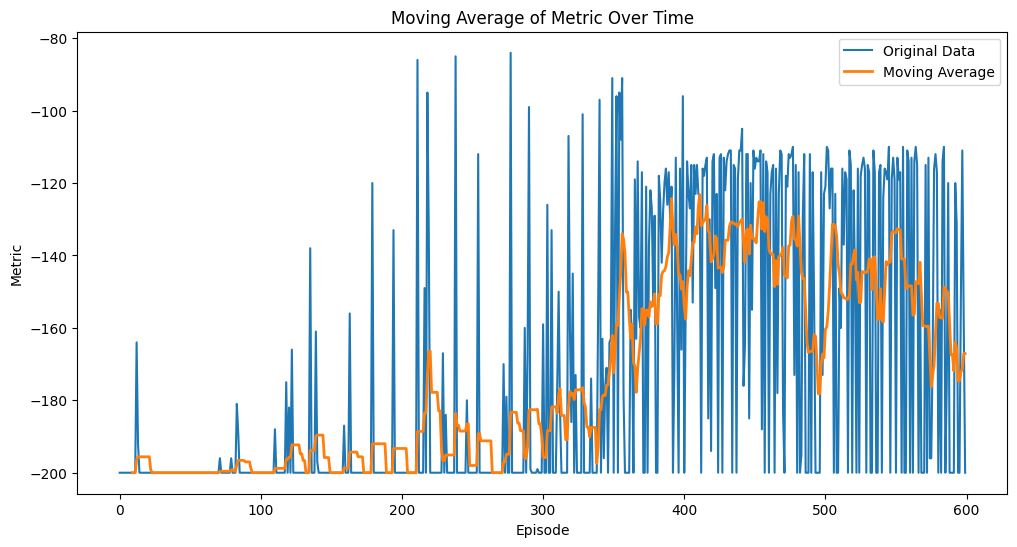

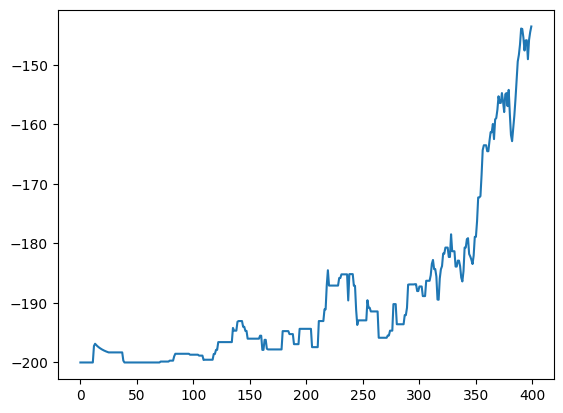

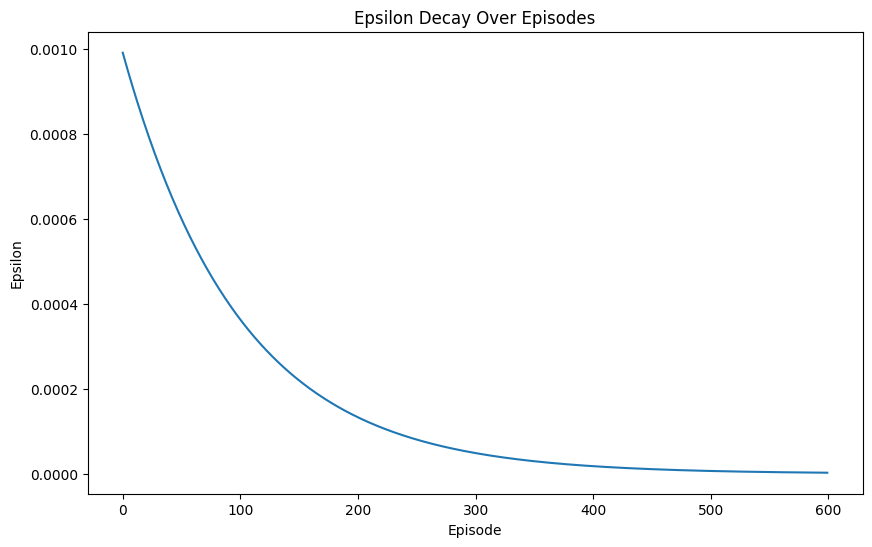

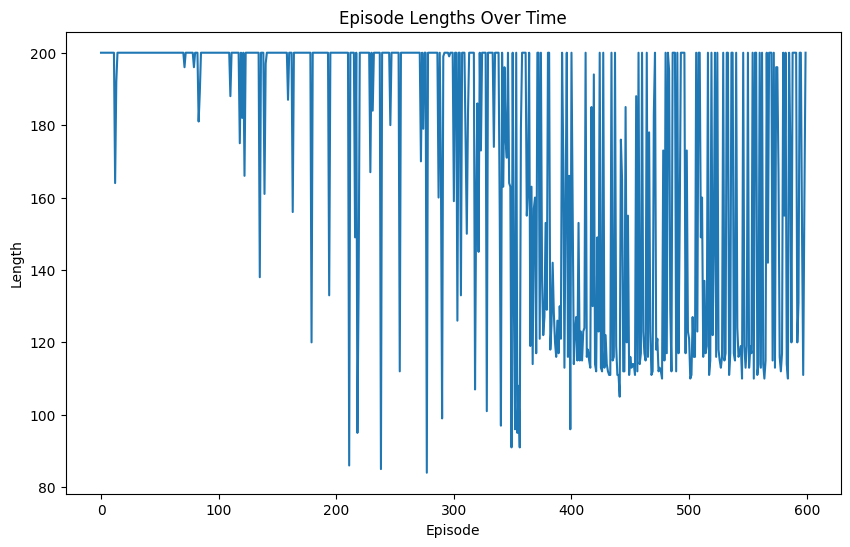

In [29]:
# plot Rewards vs Episodes
plt.plot(rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

# plot Moving Average of Rewards with window size 10
data = rewards
data_series = pd.Series(data)
window_size = 10
moving_average = data_series.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.plot(moving_average, label='Moving Average', linewidth=2)
plt.title("Moving Average of Metric Over Time")
plt.xlabel("Episode")
plt.ylabel("Metric")
plt.legend()
plt.show()

# plot Moving Average of Rewards with window size 25
mean_rewards = np.zeros(400)
for t in range(400):
    mean_rewards[t] = np.mean(rewards[max(0,t-25):(t+1)])
plt.plot(mean_rewards)

# plot Epsilon Decay Over Episodes
epsilons = [EPSILON * (EPSILON_DECAY ** episode) for episode in range(EPISODES)]

# plot Episode Lengths Over Time
plt.figure(figsize=(10, 6))
plt.plot(epsilons)
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()

# plot Episode Lengths Over Time
plt.figure(figsize=(10, 6))
plt.plot(episode_lengths)
plt.title("Episode Lengths Over Time")
plt.xlabel("Episode")
plt.ylabel("Length")
plt.show()


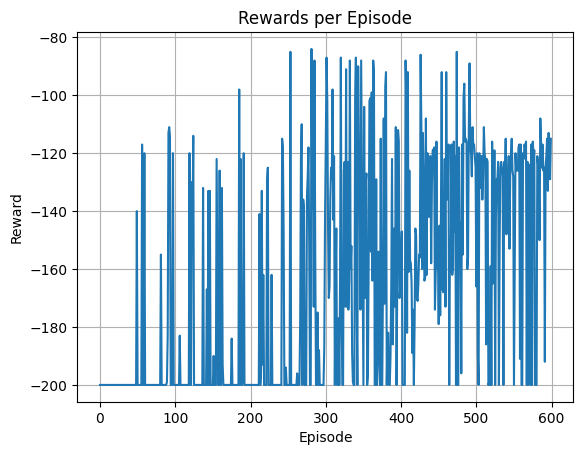

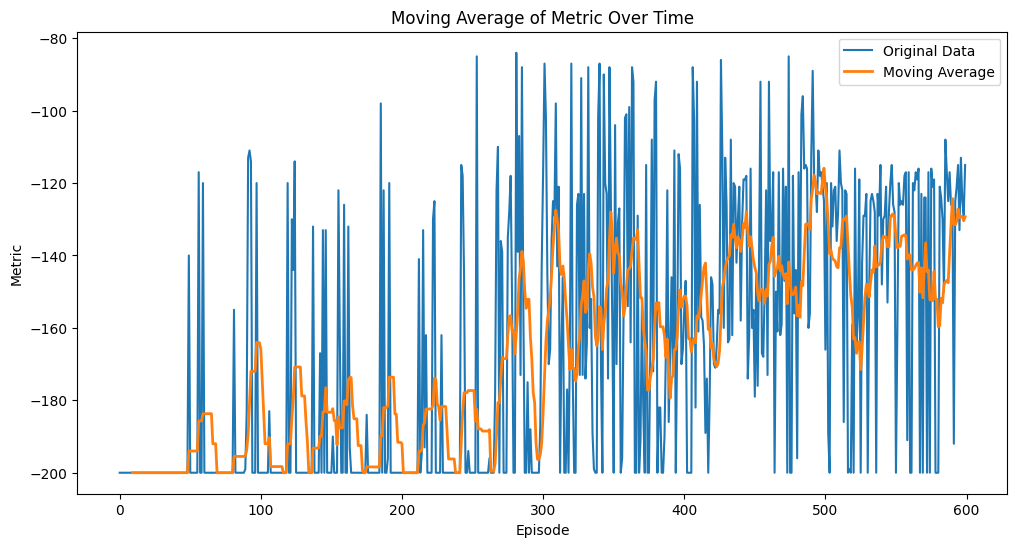

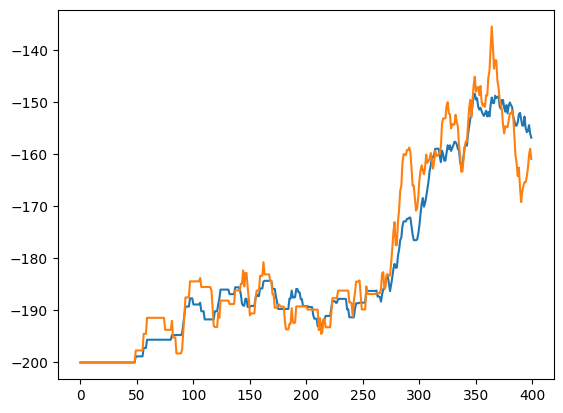

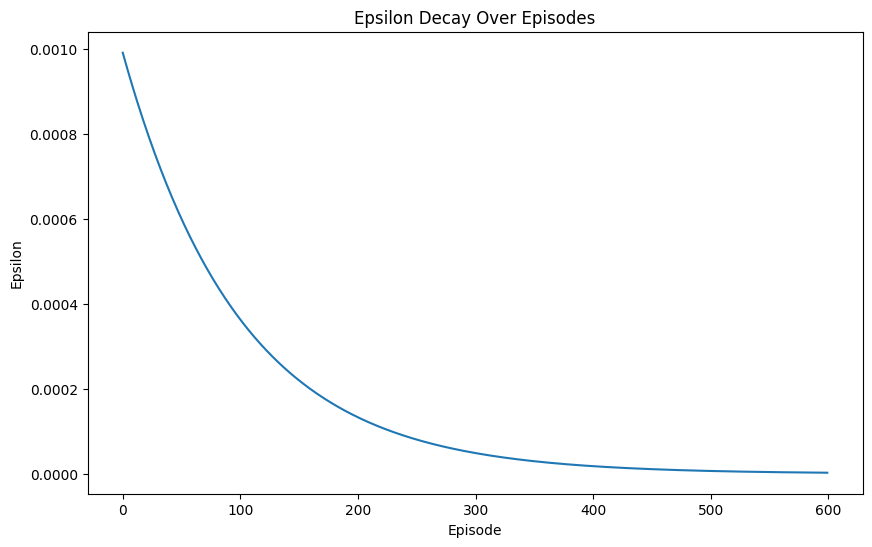

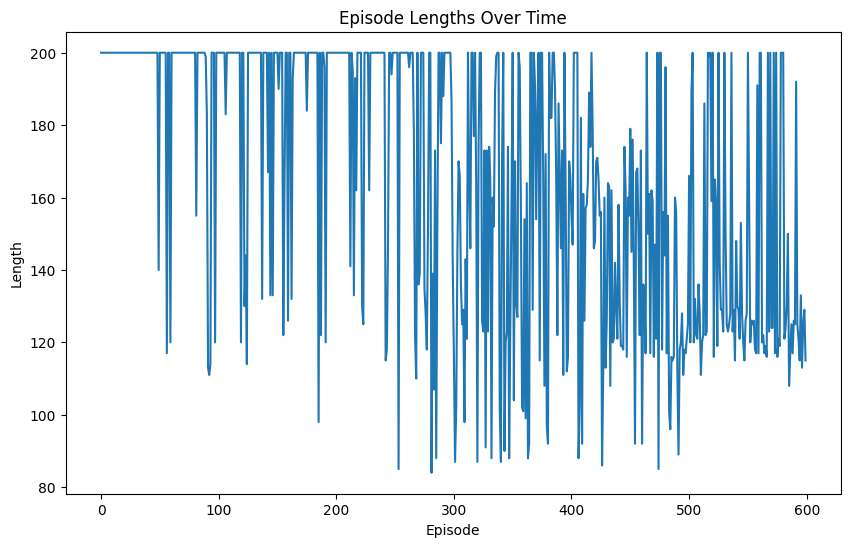

In [ ]:
# plot Rewards vs Episodes
plt.plot(rewards)
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()

# plot Moving Average of Rewards with window size 10
data = rewards
data_series = pd.Series(data)
window_size = 10
moving_average = data_series.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.plot(moving_average, label='Moving Average', linewidth=2)
plt.title("Moving Average of Metric Over Time")
plt.xlabel("Episode")
plt.ylabel("Metric")
plt.legend()
plt.show()

# plot Moving Average of Rewards with window size 25
mean_rewards = np.zeros(400)
for t in range(400):
    mean_rewards[t] = np.mean(rewards[max(0,t-25):(t+1)])
plt.plot(mean_rewards)

# plot Epsilon Decay Over Episodes
epsilons = [EPSILON * (EPSILON_DECAY ** episode) for episode in range(EPISODES)]

# plot Episode Lengths Over Time
plt.figure(figsize=(10, 6))
plt.plot(epsilons)
plt.title("Epsilon Decay Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()

# plot Episode Lengths Over Time
plt.figure(figsize=(10, 6))
plt.plot(episode_lengths)
plt.title("Episode Lengths Over Time")
plt.xlabel("Episode")
plt.ylabel("Length")
plt.show()
